# Durations x Task x Outcome Matrix (12x12)

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

## Load Z-scored Data

In [18]:
final_discrim_path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/data/finalDiscrimMatched/z_scored_RT/final_discrim.csv'


In [19]:
final_discrim = pd.read_csv(final_discrim_path)


In [20]:
final_discrim_125 = final_discrim.loc[final_discrim['duration'] == 125]
final_discrim_250 = final_discrim.loc[final_discrim['duration'] == 250]
final_discrim_1000 = final_discrim.loc[final_discrim['duration'] == 1000]

In [5]:
VE_data_125_path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/z_scored_125_data.csv'

VE_data_250_path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/z_scored_250_data.csv'

VE_data_1000_path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/z_scored_1000_data.csv'


In [11]:
VE_data_125 = pd.read_csv(VE_data_125_path)
VE_data_250 = pd.read_csv(VE_data_250_path)
VE_data_1000 = pd.read_csv(VE_data_1000_path)


In [9]:
def get_stimuli(duration_df):
    """
    Args:
        duration df 
    Returns:
        all_stimuli
    """
    
    stimuli = set()
    for idx, row in duration_df.iterrows():
        stimulus = row["stimulus"]
        stimuli.add(stimulus)
        
    return list(stimuli)

def rand_data(duration_df, proportion):
    """
    Args
        Data post outlier removal: i.e. cleaned_data 
        proportion - amount of data in each split (0.5 for 50/50 split)
    """
    
    stimuli = get_stimuli(duration_df)
    
    rand0_y = []
    rand0_std = []
    rand0_ste = []
    rand0_stim = []
    
    rand0_all_ys = []
    
    rand0_subjIDs = []
    
    rand0_RTs = []
    
    rand1_y = []
    rand1_std = []
    rand1_ste = []
    rand1_stim = []
    
    rand1_all_ys = []
    
    rand1_subjIDs = []
    
    rand1_RTs = []

    grouped = duration_df.groupby(duration_df.stimulus) 
    for stim in stimuli:   
        stim_df = grouped.get_group(stim)
        stim_df_estimates = stim_df['depth_estimate'].tolist()
        stim_df_RTs = stim_df['trial_RT'].tolist()
        stim_df_subjIDs = stim_df['subjID'].tolist()
        
        # Shuffle two lists with same order
        # Using zip() + * operator + shuffle()
        temp = list(zip(stim_df_subjIDs, stim_df_estimates, stim_df_RTs))
        random.shuffle(temp)
        random.shuffle(temp)
        shuffled_subjIDs, shuffled_estimates, shuffled_RTs = zip(*temp)
        # res1 and res2 come out as tuples, and so must be converted to lists.
        shuffled_subjIDs, shuffled_estimates, shuffled_RTs = list(shuffled_subjIDs), list(shuffled_estimates), list(shuffled_RTs)
        
        rand0_all_ys.append(np.array(shuffled_estimates[0:int(len(shuffled_estimates)*proportion)]))
        rand0_subjIDs.append(np.array(shuffled_subjIDs[0:int(len(shuffled_subjIDs)*proportion)]))
        rand0_RTs.append(np.array(shuffled_RTs[0:int(len(shuffled_RTs)*proportion)]))
        
        estim_avg_df0 = np.mean(np.array(shuffled_estimates[0:int(len(shuffled_estimates)*proportion)]))
        estim_std0 = np.std(np.array(shuffled_estimates[0:int(len(shuffled_estimates)*proportion)]))
        estim_ste0 = stats.sem(np.array(shuffled_estimates[0:int(len(shuffled_estimates)*proportion)]))
        
        rand0_y.append(estim_avg_df0) 
        rand0_std.append(estim_std0)
        rand0_ste.append(estim_ste0)
        rand0_stim.append(stim)
        

   
    
    rand0_y = np.array(rand0_y).reshape(1,-1)[0]
    rand0_std = np.array(rand0_std).reshape(1,-1)[0]
    rand0_ste = np.array(rand0_ste).reshape(1,-1)[0]
    rand0_stim = np.array(rand0_stim).reshape(1,-1)[0]
    
    rand0_df = pd.DataFrame(columns=('subjID', 'stimulus', 'depth_estimate', 'trial_RT'))
    

    
    c = 0
    # loop through all stimuli
    for i, stim in enumerate(rand0_stim):
        # loop through all the subjects that have data for that stimulus
        for j in range(len(rand0_subjIDs[i])):
            # add to the df the subject id, the subjects estimate, and the stimulus name
            # df has a seperate row for each subjects response 
            rand0_df.loc[c] = [rand0_subjIDs[i][j], stim, rand0_all_ys[i][j], rand0_RTs[i][j]]
            c += 1
            

            
    return [rand0_y, rand0_std, rand0_ste, rand0_stim], rand0_df



In [12]:
r0_125, r0_125_df = rand_data(VE_data_125, 1)
r0_250, r0_250_df = rand_data(VE_data_250, 1)
r0_1000, r0_1000_df = rand_data(VE_data_1000, 1)

In [48]:
def get_accuracy(df):
    """
    * ACCURACY BASED ON THE KINECT
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    
    return count_correct/count_total, count_correct, count_total, count_missed

def get_RT(df):
    """    
    args:
        df  
    returns:
        array of RTs, avg RT, std, ste 
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        RT = row["trial_RT"] 
        list_RTs.append(RT)
    
    list_RTs = np.array(list_RTs)
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)

In [49]:
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = [elem for elem in df.stimulus_0.unique() if type(elem) == str ]

    stimuli_stats_split0 = {}
    stimuli_stats_split1 = {}
    
    split0 = []
    split1 = []
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_125_df = stim_df[stim_df['duration'] == 125.0]
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
                
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        kinect_answer = stim0_df.kinect_answer.unique()[0]
        
        #### SPLIT DATA INTO HALF AND CREATE STIMULI STATS PER HALF PER DURATION ####
        
        # Creating a dataframe with 50%
        # values of original dataframe
        stim_125_df_split0 = stim_125_df.sample(frac = 1)
        split0.append(stim_125_df_split0)
        
        # Creating a dataframe with 50%
        # values of original dataframe
        stim_250_df_split0 = stim_250_df.sample(frac = 1)
        split0.append(stim_250_df_split0)

        # Creating a dataframe with 50%
        # values of original dataframe
        stim_1000_df_split0 = stim_1000_df.sample(frac = 1)
        split0.append(stim_1000_df_split0)
        
        # SPLIT 1
        stim_acc_125_s0 = get_accuracy(stim_125_df_split0)
        stim_acc_250_s0 = get_accuracy(stim_250_df_split0)
        stim_acc_1000_s0 = get_accuracy(stim_1000_df_split0)

        stim_RT_125_s0 = get_RT(stim_125_df_split0)
        stim_RT_250_s0 = get_RT(stim_250_df_split0)
        stim_RT_1000_s0 = get_RT(stim_1000_df_split0)

        stimuli_stats_split0[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125_s0,
                                    'accuracy_250': stim_acc_250_s0,
                                    'accuracy_1000': stim_acc_1000_s0,
                                    'avg_depth': stim_depthbin,
                                    'depthdifference': stim_depthdiff, 
                                    'RT_125': stim_RT_125_s0,
                                    'RT_250': stim_RT_250_s0,
                                    'RT_1000': stim_RT_1000_s0,
                                    'kinect_answer': kinect_answer}
    
    return stimuli_stats_split0, pd.concat(split0)


In [50]:
all_discrim_performance_s0, final_discrim_s0 = individual_discrimination_stats(final_discrim)


In [52]:
def get_answerkey(discrim_performance, VE_data):
    '''
    Generates discrimination trial answer key based off of verbal judgement data
    '''
    answerkey = {}
    
    final_y = VE_data[0]
    final_std = VE_data[1]
    final_ste = VE_data[2]
    final_stim = VE_data[3]

    for key in discrim_performance.keys():
        targetimg0 = key.split('/')[-1]
        folder0 = targetimg0[:-11]
        depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
        idx0 = np.where(final_stim == depth_dur_path0)[0][0]
        avg_estim_stim0 = final_y[idx0]
        std0 = final_std[idx0]
        ste0 = final_ste[idx0]
    
        targetimg1 = discrim_performance[key]['stimulus_1'].split('/')[-1]
        folder1 = targetimg1[:-11]
        depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
        idx1= np.where(final_stim == depth_dur_path1)[0][0]
        avg_estim_stim1 = final_y[idx1]
        std1 = final_std[idx1]
        ste1 = final_ste[idx1]
    
        kinect_answer = discrim_performance[key]['kinect_answer'].split('/')[-1]

        if avg_estim_stim0 < avg_estim_stim1:
            # Which target is CLOSER to you?
            answer = targetimg0
        if avg_estim_stim0 == avg_estim_stim1:
            print(targetimg0, targetimg1)
        if avg_estim_stim0 > avg_estim_stim1:
            answer = targetimg1

        answerkey[key] = {'stimulus_1': targetimg1,
                                   'stimulus_0_avg_estim': avg_estim_stim0,
                                   'stimulus_1_avg_estim': avg_estim_stim1,
                                   'answer': answer,
                                   'std0': std0,
                                   'std1': std1,
                                   'kinect_answer': kinect_answer}
        
    return answerkey
    

In [53]:
ak0_125 = get_answerkey(all_discrim_performance_s0, r0_125)
ak0_250 = get_answerkey(all_discrim_performance_s0, r0_250)
ak0_1000 = get_answerkey(all_discrim_performance_s0, r0_1000)

### VE Coded Accuracy

In [55]:
def VE_accuracy(stim0, df, answerkey):
    '''
    Accuracy based on the verbal judgement data 
    '''
    
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    
    VE_correct_answer = answerkey[stim0]['answer']
    kinect_correct_answer = answerkey[stim0]['kinect_answer']
    
    for idx, row in df.iterrows(): 
        choice = row["discrim_choice"]
        count_total += 1
        if choice == 0.0: image_choice = row["stimulus_0"]
                
        if choice == 1.0: image_choice = row["stimulus_1"]
                
        if choice == 2.0: count_missed += 1
            
        if choice == 3.0: count_missed += 1
        
        try:
            if image_choice.split('/')[-1] == VE_correct_answer: count_correct += 1
        except: pass
        
#     standardError = (0.5*(1-0.5))/count_total
    p = count_correct/count_total
    standardError = np.sqrt((p*(1-p))/count_total)
    
    if VE_correct_answer == kinect_correct_answer:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'pos'
    else:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'neg'

    
def main_VE_coded_discrim_accuracy(df, answerkey_125, answerkey_250, answerkey_1000):
    '''
    Args:
        df: final discrimination dataframe
        answerkey_250 & answerkey_1000: VE coded answer key
    '''
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        # dataframe for stimulus 0
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        # name of stimulus 1
        other_stim = stim0_df.stimulus_1.unique()[0]
        # dataframe where stimulus 0 is presented SECOND (same trial)
        stim1_df = df.loc[df['stimulus_1'] == stim0]

        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_125_df = stim_df[stim_df['duration'] == 125.0]
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 

        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))

        stim_acc_125 = VE_accuracy(stim0, stim_125_df, answerkey_125)
        stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
        stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)

        stim_RT_125 = get_RT(stim_125_df)
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)

        # difference between verbal judgements divided by joint variance 
        # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
            
        std0_125 = answerkey_125[stim0]['std0']
        std1_125 = answerkey_125[stim0]['std1']
        joint_variance_125 = np.sqrt(std0_125**2 + std1_125**2)
        JV_regressor_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])/joint_variance_125

        std0_250 = answerkey_250[stim0]['std0']
        std1_250 = answerkey_250[stim0]['std1']
        joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
        JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250

        std0_1000 = answerkey_1000[stim0]['std0']
        std1_1000 = answerkey_1000[stim0]['std1']
        joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
        JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
            
        if stim_acc_125[-1] == 'pos':
            VE_depthdifference_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])
        else:
            VE_depthdifference_125 = -(abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim']))
            
        if stim_acc_250[-1] == 'pos':
            VE_depthdifference_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])
        else:
            VE_depthdifference_250 = -(abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']))
            
        if stim_acc_1000[-1] == 'pos':
            VE_depthdifference_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])
        else:
            VE_depthdifference_1000 = -(abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']))
            
        stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'accuracy_250': stim_acc_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'avg_depth': stim_depthbin,
                                    'VE_depthdifference_125': VE_depthdifference_125,
                                    'VE_depthdifference_250': VE_depthdifference_250, 
                                    'VE_depthdifference_1000': VE_depthdifference_1000,
                                    'RT_125': stim_RT_125,
                                    'RT_250': stim_RT_250,
                                    'RT_1000': stim_RT_1000,
                                    'JV_regressor_125': JV_regressor_125,
                                    'JV_regressor_250': JV_regressor_250,
                                    'JV_regressor_1000': JV_regressor_1000}
#         try:
#             # dataframe for stimulus 0
#             stim0_df = df.loc[df['stimulus_0'] == stim0]
#             # name of stimulus 1
#             other_stim = stim0_df.stimulus_1.unique()[0]
#             # dataframe where stimulus 0 is presented SECOND (same trial)
#             stim1_df = df.loc[df['stimulus_1'] == stim0]

#             # df for a specific discrimination trial (collapsed on stim presentation order)
#             stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
#             stim_125_df = stim_df[stim_df['duration'] == 125.0]
#             stim_250_df = stim_df[stim_df['duration'] == 250.0]
#             stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 

#             stim0_depth = stim_df['actual_depth_0'][0]
#             stim1_depth = stim_df['actual_depth_1'][0]
#             stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))

#             stim_acc_125 = VE_accuracy(stim0, stim_125_df, answerkey_125)
#             stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
#             stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)

#             stim_RT_125 = get_RT(stim_125_df)
#             stim_RT_250 = get_RT(stim_250_df)
#             stim_RT_1000 = get_RT(stim_1000_df)

#             # difference between verbal judgements divided by joint variance 
#             # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
            
#             std0_125 = answerkey_125[stim0]['std0']
#             std1_125 = answerkey_125[stim0]['std1']
#             joint_variance_125 = np.sqrt(std0_125**2 + std1_125**2)
#             JV_regressor_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])/joint_variance_125

#             std0_250 = answerkey_250[stim0]['std0']
#             std1_250 = answerkey_250[stim0]['std1']
#             joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
#             JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250

#             std0_1000 = answerkey_1000[stim0]['std0']
#             std1_1000 = answerkey_1000[stim0]['std1']
#             joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
#             JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
            
#             if stim_acc_125[-1] == 'pos':
#                 VE_depthdifference_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])
#             else:
#                 VE_depthdifference_125 = -(abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim']))
            
#             if stim_acc_250[-1] == 'pos':
#                 VE_depthdifference_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])
#             else:
#                 VE_depthdifference_250 = -(abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']))
            
#             if stim_acc_1000[-1] == 'pos':
#                 VE_depthdifference_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])
#             else:
#                 VE_depthdifference_1000 = -(abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']))
            
#             stimuli_stats[stim0] = {'stimulus_1': other_stim,
#                                     'accuracy_125': stim_acc_125,
#                                     'accuracy_250': stim_acc_250,
#                                     'accuracy_1000': stim_acc_1000,
#                                     'avg_depth': stim_depthbin,
#                                     'VE_depthdifference_125': VE_depthdifference_125,
#                                     'VE_depthdifference_250': VE_depthdifference_250, 
#                                     'VE_depthdifference_1000': VE_depthdifference_1000,
#                                     'RT_125': stim_RT_125,
#                                     'RT_250': stim_RT_250,
#                                     'RT_1000': stim_RT_1000,
#                                     'JV_regressor_125': JV_regressor_125,
#                                     'JV_regressor_250': JV_regressor_250,
#                                     'JV_regressor_1000': JV_regressor_1000}
    
#         except:
#             print(stim0)

    return stimuli_stats
    

In [56]:
VE_coded_discrim_performance0 = main_VE_coded_discrim_accuracy(final_discrim_s0, ak0_125, ak0_250, ak0_1000)

In [58]:
def get_discrimination_results(discrim_performance, duration):
    '''
    Returns lists of discrimination data results
    '''
    if duration == 125:
        n_VE_estim_diff = [discrim_performance[elem]['VE_depthdifference_125'] for elem in discrim_performance]
        n_VE_accuracy = [discrim_performance[elem]['accuracy_125'][0] for elem in discrim_performance]
        n_VE_ste = [discrim_performance[elem]['accuracy_125'][-2] for elem in discrim_performance]
        n_avg_RT = [discrim_performance[elem]['RT_125'][1] for elem in discrim_performance]
        n_avg_RT_ste = [discrim_performance[elem]['RT_125'][-1] for elem in discrim_performance]
        n_JV = [discrim_performance[elem]['JV_regressor_125'] for elem in discrim_performance]
        
    if duration == 250:
        n_VE_estim_diff = [discrim_performance[elem]['VE_depthdifference_250'] for elem in discrim_performance]
        n_VE_accuracy = [discrim_performance[elem]['accuracy_250'][0] for elem in discrim_performance]
        n_VE_ste = [discrim_performance[elem]['accuracy_250'][-2] for elem in discrim_performance]
        n_avg_RT = [discrim_performance[elem]['RT_250'][1] for elem in discrim_performance]
        n_avg_RT_ste = [discrim_performance[elem]['RT_250'][-1] for elem in discrim_performance]
        n_JV = [discrim_performance[elem]['JV_regressor_250'] for elem in discrim_performance]
        
    if duration == 1000:
        n_VE_estim_diff = [discrim_performance[elem]['VE_depthdifference_1000'] for elem in discrim_performance]
        n_VE_accuracy = [discrim_performance[elem]['accuracy_1000'][0] for elem in discrim_performance]
        n_VE_ste = [discrim_performance[elem]['accuracy_1000'][-2] for elem in discrim_performance]
        n_avg_RT = [discrim_performance[elem]['RT_1000'][1] for elem in discrim_performance]
        n_avg_RT_ste = [discrim_performance[elem]['RT_1000'][-1] for elem in discrim_performance]
        n_JV = [discrim_performance[elem]['JV_regressor_1000'] for elem in discrim_performance]

    n_stim = [elem for elem in discrim_performance]      
    
    return n_VE_estim_diff, n_VE_accuracy, n_VE_ste, n_avg_RT, n_avg_RT_ste, n_JV, n_stim

In [59]:
discrimination_results0_125 = get_discrimination_results(VE_coded_discrim_performance0, 125)
discrimination_results0_250 = get_discrimination_results(VE_coded_discrim_performance0, 250)
discrimination_results0_1000 = get_discrimination_results(VE_coded_discrim_performance0, 1000)

### Derive Performance for VE 

In [60]:
def VE_performance(stimuli, duration_df, discrimination_performance, duration_answerkey):
    '''
    Args:
        stimuli:  depth discrimination stimuli list 
        duration_df: filtered VE duration dataframe 
        discrimination performance: dictionary of discrim performance 
    '''
    
    VE_Performance = {}
            
    for im0 in stimuli:
        performance = []
        # loop through all participants
        for subjID in duration_df.subjID.unique():
            # filter to just the subjects data df
            subjdf = duration_df.loc[duration_df['subjID'] == subjID]
            
            try:
                im0_VE = 'depth_duration_stimuli/' + im0.split('/')[1] + '/' + im0.split('/')[2]
                im0_row = subjdf.loc[subjdf['stimulus'] == im0_VE]
                im0_estimate = im0_row['depth_estimate'].tolist()[0]

                im1 = discrimination_performance[im0]['stimulus_1'][29:]
                im1_VE = 'depth_duration_stimuli/' + im1
                im1_row = subjdf.loc[subjdf['stimulus'] == im1_VE]
                im1_estimate = im1_row['depth_estimate'].tolist()[0]
                

                if im0_estimate < im1_estimate:
                    p_ans = im0.split('/')[-1]
                else:
                    p_ans = im1.split('/')[-1]
                try:
                    answerkey_answer = duration_answerkey[im0]['answer']
                except:
                    answerkey_answer = duration_answerkey['depth_discrimination_stimuli/' + im1]['answer']
                if p_ans == answerkey_answer:
                    trial_acc = 0 # CORRECT
                    performance.append(trial_acc)
                else:
                    trial_acc = 1 # INCORRECT
                    performance.append(trial_acc)
            
            except:
                pass
        VE_Performance[im0] = performance

    VE_PC = {}

    for key in VE_Performance:
        performance = VE_Performance[key]
        correct_count = performance.count(0)
        incorrect_count = performance.count(1)
        total = len(performance)
        pc = correct_count/total
        VE_PC[key] = pc
    
    return VE_PC
    
    

In [61]:
VE_performance0_125 = VE_performance(discrimination_results0_125[-1], r0_125_df, VE_coded_discrim_performance0, ak0_125)
VE_performance0_250 = VE_performance(discrimination_results0_250[-1], r0_250_df, VE_coded_discrim_performance0, ak0_250)
VE_performance0_1000 = VE_performance(discrimination_results0_1000[-1], r0_1000_df, VE_coded_discrim_performance0, ak0_1000)


### Matched Discrimination Performance (Accuracy and RT)

In [70]:
def matched_performance(VE_Performance, discrimination_performance, duration):
    '''
    Args:
        VE_performance: dict of VE performance for a specific duration
        discrimination_performance: complete discrim performance
        duration: int, duration value
    Returns:
        Trial matched VE and Discrimination performance
        List of stimuli 
        
    '''
    Discrim_VEmatched_PC = {}
    all_stim = []
    all_VE_PC = []
    all_Discrim_VEmatched_PC = []

    for key in VE_Performance:
        
        im_VE_PC = VE_Performance[key]
        if duration == 125:
            im_Discrim_PC = discrimination_performance[key]['accuracy_125'][0]
        if duration == 250:
            im_Discrim_PC = discrimination_performance[key]['accuracy_250'][0]
        if duration == 1000:
            im_Discrim_PC = discrimination_performance[key]['accuracy_1000'][0]
        Discrim_VEmatched_PC[key] = [im_VE_PC, im_Discrim_PC]

        all_stim.append(key)
        all_VE_PC.append(im_VE_PC)
        all_Discrim_VEmatched_PC.append(im_Discrim_PC)
        
    return all_Discrim_VEmatched_PC, all_VE_PC, all_stim

In [71]:
m_discrim_performance0_125, m_VE_performance0_125, m_stim0_125 = matched_performance(VE_performance0_125, VE_coded_discrim_performance0, 125)
m_discrim_performance0_250, m_VE_performance0_250, m_stim0_250 = matched_performance(VE_performance0_250, VE_coded_discrim_performance0, 250)
m_discrim_performance0_1000, m_VE_performance0_1000, m_stim0_1000 = matched_performance(VE_performance0_1000, VE_coded_discrim_performance0, 1000)


In [73]:
def get_RT_performance(duration_df, discrimination_performance, duration):
    '''
    Args:
        duration_df: filtered VE duration dataframe
        discrimination_performance: dict of discrimination performance
        duration: int value for duration 
    ReturnsL
    arr_discrim_RT: array of RTs for discrimination trials
    arr_discrim_RT_ste: array of ste of RT for each discrimination trial
    arr_VE_RT: array of RTs for VE trials
    stim_RT: list of stimuli that is matched with arr_discrim_RT and arr_VE_RT 
    '''
    
    arr_discrim_RT = []
    arr_discrim_RT_ste = []
    arr_VE_RT = []
    stim_RT = []


    for key in discrimination_performance:
        stim_RT.append(key)
        im0 = key.split('/')[1]
        im1 = discrimination_performance[key]['stimulus_1'].split('/')[1]
        if duration == 125:
            dtrial_RT = discrimination_performance[key]['RT_125'][1]
            dtrial_RT_ste = discrimination_performance[key]['RT_125'][-1]
        if duration == 250:
            dtrial_RT = discrimination_performance[key]['RT_250'][1]
            dtrial_RT_ste = discrimination_performance[key]['RT_250'][-1]
        if duration == 1000:
            dtrial_RT = discrimination_performance[key]['RT_1000'][1]
            dtrial_RT_ste = discrimination_performance[key]['RT_1000'][-1]

            
        arr_discrim_RT.append(dtrial_RT)
        arr_discrim_RT_ste.append(dtrial_RT_ste)
        
        RTs = []
        # loop through all participants
        for subjID in duration_df.subjID.unique():
            # filter to just the subjects data df
            subjdf = duration_df.loc[duration_df['subjID'] == subjID]
            
            try:
                im0_VE = 'depth_duration_stimuli/' + key.split('/')[1] + '/' + key.split('/')[2]
                im0_row = subjdf.loc[subjdf['stimulus'] == im0_VE]
                im0_RT = im0_row['trial_RT'].tolist()[0]

                im1 = discrimination_performance[key]['stimulus_1'][29:]
                im1_VE = 'depth_duration_stimuli/' + im1
                im1_row = subjdf.loc[subjdf['stimulus'] == im1_VE]
                im1_RT = im1_row['trial_RT'].tolist()[0]
                
                RTs.append(im0_RT + im1_RT)
            
            except:
                pass
        
        arr_VE_RT.append(np.mean(np.array(RTs)))
        
    return arr_discrim_RT, arr_discrim_RT_ste, arr_VE_RT, stim_RT


In [74]:
m_discrim_RT0_125, m_discrim_RT0_ste_125, m_VE_RT0_125, m_RT0_stim_125 = get_RT_performance(r0_125_df, VE_coded_discrim_performance0, 125) 
m_discrim_RT0_250, m_discrim_RT0_ste_250, m_VE_RT0_250, m_RT0_stim_250 = get_RT_performance(r0_250_df, VE_coded_discrim_performance0, 250) 
m_discrim_RT0_1000, m_discrim_RT0_ste_1000, m_VE_RT0_1000, m_RT0_stim_1000 = get_RT_performance(r0_1000_df, VE_coded_discrim_performance0, 1000)


In [75]:
data = {'Discrim PC @ 125 ms': m_discrim_performance0_125,
        'Discrim PC @ 250 ms': m_discrim_performance0_250,
        'Discrim PC @ 1000 ms': m_discrim_performance0_1000,
        'VE PC @ 125 ms': m_VE_performance0_125,
        'VE PC @ 250 ms': m_VE_performance0_250,
        'VE PC @ 1000 ms': m_VE_performance0_1000,
        'Discrim RT @ 125 ms': m_discrim_RT0_125,
        'Discrim RT @ 250 ms': m_discrim_RT0_250,
        'Discrim RT @ 1000 ms': m_discrim_RT0_1000,
        'VE RT @ 125 ms': m_VE_RT0_125,
        'VE RT @ 250 ms': m_VE_RT0_250,
        'VE RT @ 1000 ms': m_VE_RT0_1000}

df = pd.DataFrame(data,columns=['Discrim PC @ 125 ms','Discrim PC @ 250 ms','Discrim PC @ 1000 ms','VE PC @ 125 ms','VE PC @ 250 ms', 'VE PC @ 1000 ms',
                                'Discrim RT @ 125 ms','Discrim RT @ 250 ms','Discrim RT @ 1000 ms','VE RT @ 125 ms','VE RT @ 250 ms', 'VE RT @ 1000 ms'])

df_corr = df.corr()

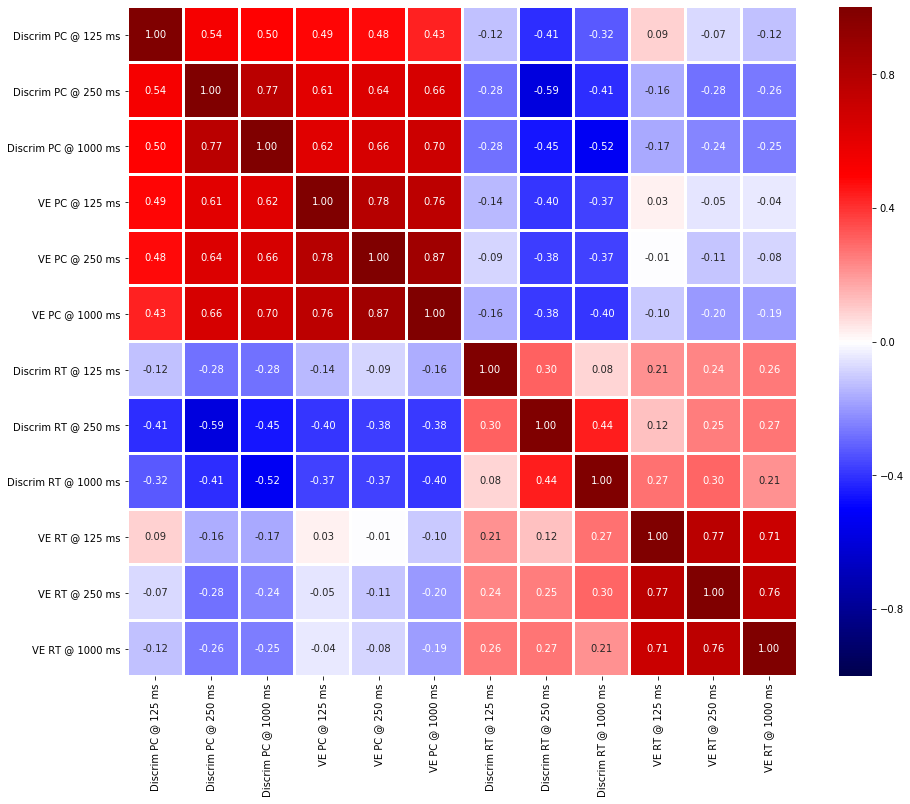

In [77]:
plt.figure(figsize=[15,15])

ax = sns.heatmap(df_corr, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap= "seismic", square=True, center=0, vmin=-1, vmax=1, edgecolors='w', linewidths=2, cbar_kws={"shrink": .82}) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# plt.title('Log Centered RT', fontsize=15)

plt.show();

m: [-0.00010683]
b: 0.8512716067245087
R-squared:  0.018332882356234648


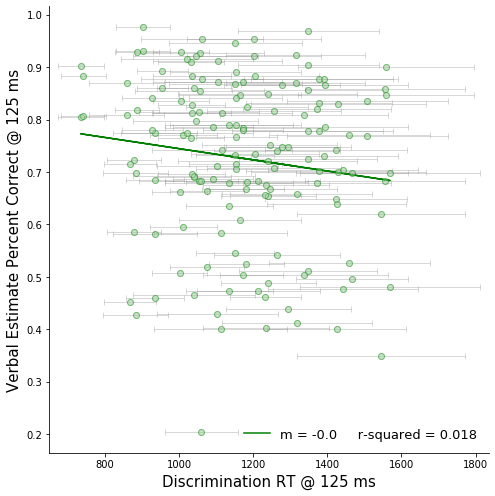

In [83]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X = np.array(m_discrim_RT0_125).reshape(-1,1)
Y = m_VE_performance0_125
reg = LinearRegression().fit(X, Y)

#Generated Predictions
predicted_Y = reg.predict(X)
#Plot Our Actual and Predicted Values

plt.errorbar(X, Y, xerr = m_discrim_RT0_ste_125, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3);
plt.plot(X, Y, 'o', color='green', alpha = 0.3);
plt.plot(X, predicted_Y,color='green', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, Y)), 3)))

plt.xlabel("Discrimination RT @ 125 ms", fontsize = 15)
plt.ylabel("Verbal Estimate Percent Correct @ 125 ms", fontsize = 15)

# plt.xlim(0.3, 1.02)
# plt.ylim(0.3, 1.02)
# plt.xticks(np.arange(6.7,7.35, 0.1))
# plt.yticks(np.arange(6.7,7.35, 0.1))


plt.margins(x=0.02)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))
#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, Y))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)
fig.tight_layout()
plt.show();


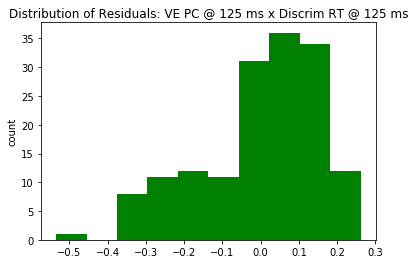

In [85]:
# residuals = Y - predicted_y
residuals_discrimRT125_VEPC125 = m_VE_performance0_125-LinearRegression().fit(np.array(m_discrim_RT0_125).reshape(-1,1), m_VE_performance0_125).predict(np.array(m_discrim_RT0_125).reshape(-1,1))


plt.hist(residuals_discrimRT125_VEPC125, color='green')
plt.title('Distribution of Residuals: VE PC @ 125 ms x Discrim RT @ 125 ms')
plt.ylabel('count')
plt.show();


m: [-0.00054885]
b: 1.1950523187107136
R-squared:  0.14273697422794085


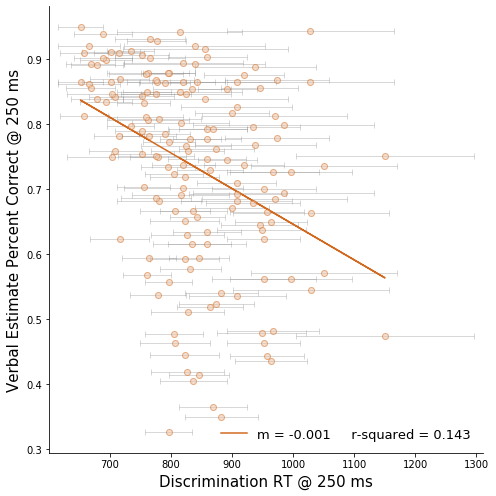

In [78]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X = np.array(m_discrim_RT0_250).reshape(-1,1)
Y = m_VE_performance0_250
reg = LinearRegression().fit(X, Y)

#Generated Predictions
predicted_Y = reg.predict(X)
#Plot Our Actual and Predicted Values

plt.errorbar(X, Y, xerr = m_discrim_RT0_ste_250, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3);
plt.plot(X, Y, 'o', color='chocolate', alpha = 0.3);
plt.plot(X, predicted_Y,color='chocolate', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, Y)), 3)))

plt.xlabel("Discrimination RT @ 250 ms", fontsize = 15)
plt.ylabel("Verbal Estimate Percent Correct @ 250 ms", fontsize = 15)

# plt.xlim(0.3, 1.02)
# plt.ylim(0.3, 1.02)
# plt.xticks(np.arange(6.7,7.35, 0.1))
# plt.yticks(np.arange(6.7,7.35, 0.1))


plt.margins(x=0.02)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))
#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, Y))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)
fig.tight_layout()
plt.show();


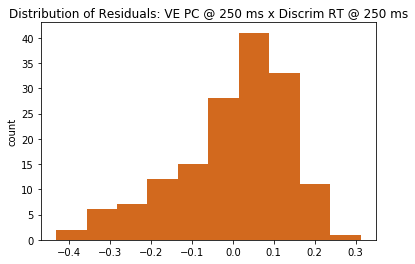

In [79]:
# residuals = Y - predicted_y
residuals_discrimRT250_VEPC250 = m_VE_performance0_250-LinearRegression().fit(np.array(m_discrim_RT0_250).reshape(-1,1), m_VE_performance0_250).predict(np.array(m_discrim_RT0_250).reshape(-1,1))


plt.hist(residuals_discrimRT250_VEPC250, color='chocolate')
plt.title('Distribution of Residuals: VE PC @ 250 ms x Discrim RT @ 250 ms')
plt.ylabel('count')
plt.show();


m: [-0.00071671]
b: 1.4347637525637666
R-squared:  0.275342678887767


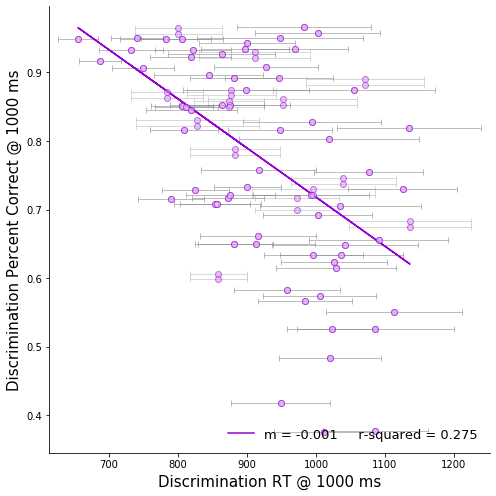

In [80]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X = np.array(m_discrim_RT0_1000).reshape(-1,1)
Y = m_discrim_performance0_1000
reg = LinearRegression().fit(X, Y)

#Generated Predictions
predicted_Y = reg.predict(X)
#Plot Our Actual and Predicted Values

plt.errorbar(X, Y, xerr = m_discrim_RT0_ste_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3);
plt.plot(X, Y, 'o', color='darkviolet', alpha = 0.3);
plt.plot(X, predicted_Y,color='darkviolet', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, Y)), 3)))

plt.xlabel("Discrimination RT @ 1000 ms", fontsize = 15)
plt.ylabel("Discrimination Percent Correct @ 1000 ms", fontsize = 15)

# plt.xlim(0.3, 1.02)
# plt.ylim(0.3, 1.02)
# plt.xticks(np.arange(6.7,7.35, 0.1))
# plt.yticks(np.arange(6.7,7.35, 0.1))


plt.margins(x=0.02)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))
#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, Y))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)
fig.tight_layout()
plt.show();


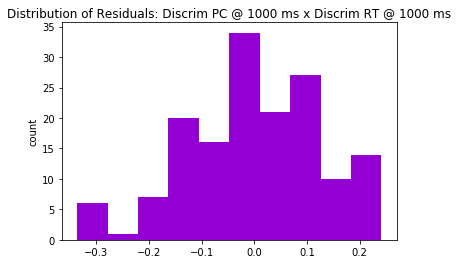

In [81]:
# residuals = Y - predicted_y
residuals_discrimRT1000_discrimPC1000 = m_discrim_performance0_1000-LinearRegression().fit(np.array(m_discrim_RT0_1000).reshape(-1,1), m_discrim_performance0_1000).predict(np.array(m_discrim_RT0_1000).reshape(-1,1))


plt.hist(residuals_discrimRT1000_discrimPC1000, color='darkviolet')
plt.title('Distribution of Residuals: Discrim PC @ 1000 ms x Discrim RT @ 1000 ms')
plt.ylabel('count')
plt.show();


In [90]:
scipy.stats.pearsonr(residuals_discrimRT125_VEPC125, residuals_discrimRT250_VEPC250) 

(0.692624468876385, 1.2993031998362448e-23)

In [93]:
scipy.stats.pearsonr(residuals_discrimRT125_VEPC125, residuals_discrimRT1000_discrimPC1000) 

(0.46793679477942995, 7.302944142080882e-10)

In [92]:
scipy.stats.pearsonr(residuals_discrimRT250_VEPC250, residuals_discrimRT1000_discrimPC1000) 

(0.4840477429068919, 1.5358026709343967e-10)

m: [-0.00076715]
b: 1.3596945318357365
R-squared:  0.34755825339581403


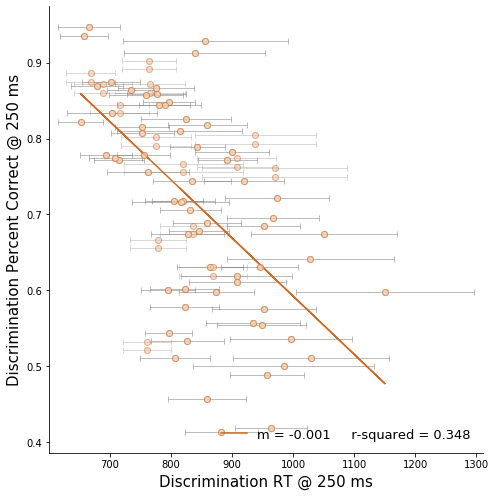

In [94]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X = np.array(m_discrim_RT0_250).reshape(-1,1)
Y = m_discrim_performance0_250
reg = LinearRegression().fit(X, Y)

#Generated Predictions
predicted_Y = reg.predict(X)
#Plot Our Actual and Predicted Values

plt.errorbar(X, Y, xerr = m_discrim_RT0_ste_250, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3);
plt.plot(X, Y, 'o', color='chocolate', alpha = 0.3);
plt.plot(X, predicted_Y,color='chocolate', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, Y)), 3)))

plt.xlabel("Discrimination RT @ 250 ms", fontsize = 15)
plt.ylabel("Discrimination Percent Correct @ 250 ms", fontsize = 15)

# plt.xlim(0.3, 1.02)
# plt.ylim(0.3, 1.02)
# plt.xticks(np.arange(6.7,7.35, 0.1))
# plt.yticks(np.arange(6.7,7.35, 0.1))


plt.margins(x=0.02)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))
#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, Y))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)
fig.tight_layout()
plt.show();


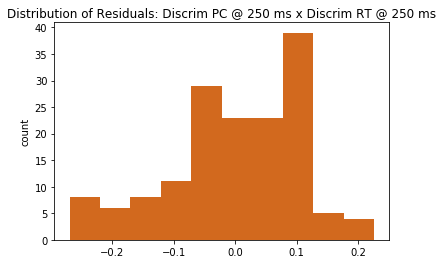

In [95]:
# residuals = Y - predicted_y
residuals_discrimRT250_discrimPC250 = m_discrim_performance0_250-LinearRegression().fit(np.array(m_discrim_RT0_250).reshape(-1,1), m_discrim_performance0_250).predict(np.array(m_discrim_RT0_250).reshape(-1,1))


plt.hist(residuals_discrimRT250_discrimPC250, color='chocolate')
plt.title('Distribution of Residuals: Discrim PC @ 250 ms x Discrim RT @ 250 ms')
plt.ylabel('count')
plt.show();